**Objective**  
1. Maximize ROMI
2. Given channel wise ROI, recommed how much to spend on which channel.

**Prerequisite**  
- Channel wise MoM historical ROI.

**Approach**  
1. This marketing budget allocation problem is a linear program.
2. Use gurobi to find the optimal budget allocation.

**Constraints**  
1. The amount invested in print and TV should be no more than the amount spent on Facebook and Email.
2. The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.
3. For each channel, the amount invested should not be more than $3M.

**Model Consideration**
1. Objective Function:
- define a linear objective function that needs to be maximized or minimized. This function is usually represented as a linear combination of decision variables.
- In this scenario, it's maximize ROMI

2. Decision Variables:
- Identify decision variables, which are the unknown quantities to be determined in the optimization process. These variables contribute to the objective function.
- 10 decision variables - given 10 platforms, each representing investment amount (Print, TV, SEO, Adwords, FB, LinkedIn, Instagram, Snapchat, Twitter, Email)
-
3.	Constraints:
- Constraints are aligned with organizational guidelines.
- Formulate linear constraints that represent the limitations or requirements of the problem. Constraints can be equalities or inequalities, and they involve the decision variables.
4. Linear Programming Model:
-	Combine the objective function and constraints to create a linear programming model. The goal is to find the values of decision variables that optimize the objective function while satisfying all constraints.

---------------------------------------------------------

**ROMI**  
ROMI = (Marketing revenue — Marketing expenses) / Marketing expenses * 100%.
- What is a good ROMI ratio?
-- According to George Deeb, a Managing Partner at a financial advisory firm, a healthy ROMI should be 5-10x on a revenue basis, or 2.5-5x on a gross profit basis. He prefers to use gross profit as the numerator and shoot for a 5x return, understanding most companies will be around 2.5x with a 50% gross margin.





## 1. Importing required libraries & data source

In [ ]:
# mount google drive
from google.colab import files, drive

drive.mount('/gdrive')

# read the 1st required file
val_set='/gdrive/My Drive/Marketing_Analytics/internal_external_roi_data.csv'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
! pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Deriving channel level budget allocation

In [ ]:
roi_df = pd.read_csv(val_set)

In [ ]:
# number of channels required for budgeting
budget = 10

# Convert column names to lowercase for case-insensitive matching
roi_df.columns = roi_df.columns.str.lower()

# Extract column names for decision variables
var_names = roi_df.columns[1:].tolist()

# Create an empty dataframe to store results
results_df = pd.DataFrame(columns=var_names + ['objective value'])

# Create a dictionary mapping column names to their respective ROI values
roi_dict_1 = dict(zip(var_names, roi_df.iloc[0][1:].values))

# Initiate model
adver_mod_1 = gp.Model()

# Decision Variables - Specify number of decision variables and assign names
adver_mod_x_1 = adver_mod_1.addMVar(len(var_names), ub=3, name=var_names)

# Specify number of decision variables and assign names
adver_mod_x_1 = adver_mod_1.addMVar(len(var_names), ub=3, name=var_names)

# Create a dictionary to map variable names to the decision variable objects
var_dict = {name: adver_mod_x_1[j] for j, name in enumerate(var_names)}

# Objective Function - Set objective using the roi_dict
adver_mod_1.setObjective(gp.quicksum(roi_dict_1[name] * var_dict[name] for name in var_names), sense=gp.GRB.MAXIMIZE)

# Add constraints
adver_mod_1.addConstr(gp.quicksum(var_dict[name] for name in var_names) <= budget)  # Marketing Budget
adver_mod_1.addConstr(var_dict['print'] + var_dict['tv'] - var_dict['facebook'] - var_dict['email'] <= 0)  # Print & TV Budget Constraint
adver_mod_1.addConstr(gp.quicksum(var_dict[social] for social in ['facebook', 'linkedin', 'instagram', 'snapchat', 'twitter'] if social in var_names ) >= 2 * var_dict['seo'] + 2 * var_dict['adwords'])  # Social Media Budget Constraint

adver_mod_1.Params.OutputFlag = 0

# Optimize the model
adver_mod_1.optimize()

optimal_allocations = list(adver_mod_x_1.x)
optimal_objvalue = adver_mod_1.objVal

# Append results to the dataframe
results_df.loc[0] = optimal_allocations + [optimal_objvalue]

results_df

Restricted license - for non-production use only - expires 2025-11-24


,print,tv,seo,adwords,facebook,linkedin,instagram,snapchat,twitter,email,objective value
0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0,0.456


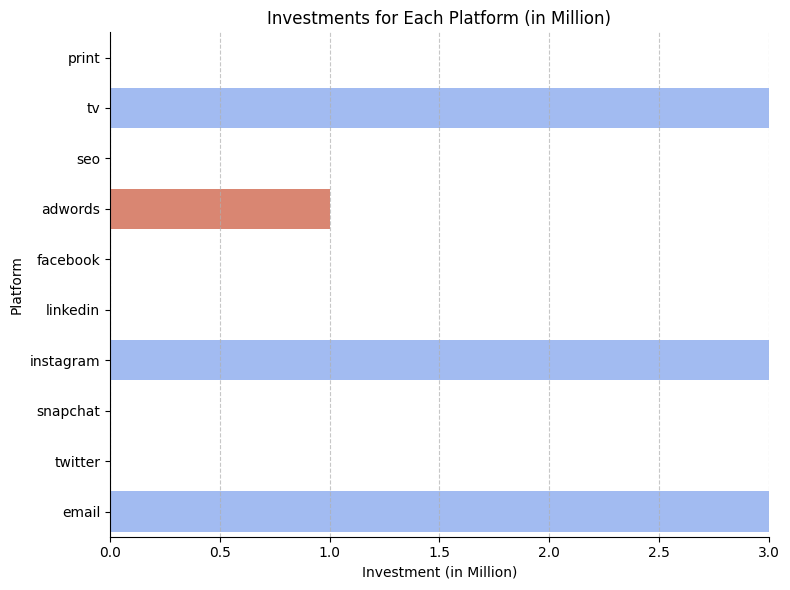

In [ ]:
# Extract the first row and drop the 'objective value' column
row1 = results_df.iloc[0].drop('objective value')

base_color = sns.color_palette("coolwarm", 10)[-2]
highlight_color = sns.color_palette("coolwarm", 10)[2]
colors = [highlight_color if value == 3 else base_color for value in row1]

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(y=row1.index, x=row1.values, palette=colors)

plt.title('Investments for Each Platform (in Million)')
plt.xlabel('Investment (in Million)')
plt.ylabel('Platform')
plt.xlim(0, 3)  # Set x-axis limit to 3 million
plt.grid(axis='x', linestyle='--', alpha=0.7)

sns.despine()

# Display the plot
plt.tight_layout()

# plt.savefig("investment_plot_1.png", format='png', dpi=300)

plt.show()

Output & Interpretation
- Output indicates towards channelising funds into highest return platforms, maximizing ROMI and ensuring efficient utlization of marketing budget.  
1. Model suggests to invest in highest ROI channel - TV/Instagram/Email > Adwords
2. Projected ROI based on this allocation = $0.456Mn
3. Pther channels didn't received any allocation, indicating that they might not be the most efficient channels for this specific marketing objective.